In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import WeibullAFTFitter, LogLogisticAFTFitter, ExponentialFitter
import seaborn as sns
import os


# Create output directory for figures if it doesn't exist
os.makedirs('figures', exist_ok=True)

# Set visualization style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

#  Load and Explore Data

In [3]:
# Load the dataset
df = pd.read_csv('Cell1.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
display(df.head())

# Check for missing values in key columns
print("\nMissing values in key columns:")
display(df[['churn', 'months']].isnull().sum())

# Basic statistics of key variables
print("\nBasic statistics of key variables:")
display(df[['churn', 'months', 'totmrc_Mean', 'mou_Mean', 'rev_Mean', 'ovrmou_Mean']].describe())

Dataset shape: (100000, 173)


,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,rev_Range,...,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,car_buy,retdays,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,25.99,...,U,U,U,U,U,Y,New,23.0,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,153.14,...,U,U,U,U,U,Y,UNKNOWN,NaN,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,0.00,...,U,Y,U,U,U,Y,New,NaN,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,0.00,...,Y,U,U,U,U,Y,New,NaN,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,0.00,...,U,U,U,U,U,Y,New,NaN,434.0,1000005



Missing values in key columns:


churn     0
months    0
dtype: int64


Basic statistics of key variables:


,churn,months,totmrc_Mean,mou_Mean,rev_Mean,ovrmou_Mean
count,100000.000000,100000.000000,99643.000000,99643.000000,99643.000000,99643.000000
mean,0.495620,18.833990,46.179136,513.559937,58.719985,41.072247
std,0.499983,9.655794,23.623489,525.168140,46.291677,97.296150
min,0.000000,6.000000,-26.915000,0.000000,-6.167500,0.000000
25%,0.000000,11.000000,30.000000,150.750000,33.260000,0.000000
50%,0.000000,16.000000,44.990000,355.500000,48.195000,2.750000
75%,1.000000,24.000000,59.990000,703.000000,70.750000,42.000000
max,1.000000,61.000000,409.990000,12206.750000,3843.262500,4320.750000


# Define Survival Time and Event Indicator


Churn distribution:
churn
0    50438
1    49562
Name: count, dtype: int64
Churn rate: 49.56%


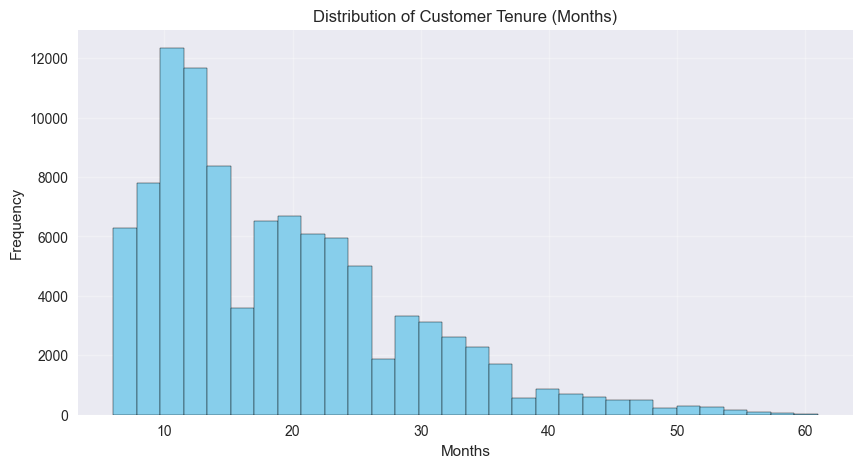

Tenure distribution plot saved to 'figures/tenure_distribution.png'


In [18]:
# Check churn distribution
churn_counts = df['churn'].value_counts()
print(f"\nChurn distribution:\n{churn_counts}")
print(f"Churn rate: {churn_counts[1] / len(df):.2%}")

# Visualize months distribution
plt.figure(figsize=(10, 5))
plt.hist(df['months'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Customer Tenure (Months)')
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.savefig('figures/tenure_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Tenure distribution plot saved to 'figures/tenure_distribution.png'")

# Variable Selection

In [19]:
def explain_variable_selection(df):
    """
    Select and explain the rationale for choosing specific variables for survival analysis.
    """
    print("VARIABLE SELECTION EXPLANATION")
    print("-" * 50)
    
    # Customer identification variables
    id_vars = ['customer_id', 'area', 'region']
    print(f"Customer Identification Variables: {id_vars}")
    print("Rationale: These variables help identify and group customers geographically.")
    
    # Dependent variable: Tenure (duration until churn)
    duration_var = 'months'
    print(f"\nDuration Variable: {duration_var}")
    print("Rationale: Represents customer tenure - the time dimension in survival analysis.")
    
    # Event indicator: Churn
    event_var = 'churn'
    print(f"\nEvent Variable: {event_var}")
    print("Rationale: Binary indicator of whether a customer has churned (event occurred) or not (censored).")
    
    # Key predictor variables with business relevance
    predictor_vars = [
        'totmou',       # Total minutes of use
        'totrev',       # Total revenue
        'avgrev',       # Average monthly revenue
        'avgmou',       # Average monthly minutes of use
        'drop_blk_Range', # Call quality metric
        'new_cell',     # New customer indicator
        'asl_flag',     # Account spending limit flag
        'prizm_social_one', # Demographic segment
        'dualband'      # Technology adoption
    ]
    
    print("\nKey Predictor Variables:")
    
    print("Usage-related Variables:")
    print("- totmou: Total minutes of use")
    print("  Rationale: Direct indicator of service usage intensity.")
    print("- avgmou: Average monthly minutes of use")
    print("  Rationale: Indicates consistent usage patterns.")
    
    print("\nRevenue-related Variables:")
    print("- totrev: Total revenue")
    print("  Rationale: Direct business impact measure.")
    print("- avgrev: Average monthly revenue")
    print("  Rationale: Indicates customer value and spending consistency.")
    
    print("\nService Quality Variables:")
    print("- drop_blk_Range: Call quality metric")
    print("  Rationale: Poor service experience is a key churn driver.")
    
    print("\nCustomer Profile Variables:")
    print("- new_cell: New customer indicator")
    print("  Rationale: New customers often have different churn patterns.")
    print("- asl_flag: Account spending limit flag")
    print("  Rationale: Credit risk indicator that may affect retention.")
    print("- prizm_social_one: Demographic segment")
    print("  Rationale: Demographic factors influence customer behavior and loyalty.")
    print("- dualband: Technology adoption")
    print("  Rationale: Technology adopters may have different engagement and loyalty.")
    
    # Return the selected variables for further analysis
    selected_vars = id_vars + [duration_var, event_var] + predictor_vars
    return selected_vars, duration_var, event_var

selected_vars, duration_var, event_var = explain_variable_selection(df)
    


VARIABLE SELECTION EXPLANATION
--------------------------------------------------
Customer Identification Variables: ['customer_id', 'area', 'region']
Rationale: These variables help identify and group customers geographically.

Duration Variable: months
Rationale: Represents customer tenure - the time dimension in survival analysis.

Event Variable: churn
Rationale: Binary indicator of whether a customer has churned (event occurred) or not (censored).

Key Predictor Variables:
Usage-related Variables:
- totmou: Total minutes of use
  Rationale: Direct indicator of service usage intensity.
- avgmou: Average monthly minutes of use
  Rationale: Indicates consistent usage patterns.

Revenue-related Variables:
- totrev: Total revenue
  Rationale: Direct business impact measure.
- avgrev: Average monthly revenue
  Rationale: Indicates customer value and spending consistency.

Service Quality Variables:
- drop_blk_Range: Call quality metric
  Rationale: Poor service experience is a key churn

# Censoring Explanation


CENSORING APPROACH EXPLANATION
--------------------------------------------------
Total observations: 100000
Uncensored (churned) observations: 49562 (49.56%)
Right-censored observations: 50438 (50.44%)

Definition of Censoring in this Analysis:
- Event (churn=1): Customer has terminated service within the observation period.
- Right-censored (churn=0): Customer was still active at the end of the observation period.

Importance of Censoring:
- Right-censoring accounts for customers who haven't experienced the event by the
  end of the observation period but might do so in the future.
- Ignoring censoring would underestimate survival probabilities and lead to
  biased conclusions about customer lifetime.
- Survival analysis methods like Kaplan-Meier and parametric models properly
  account for censored observations in estimating survival functions.


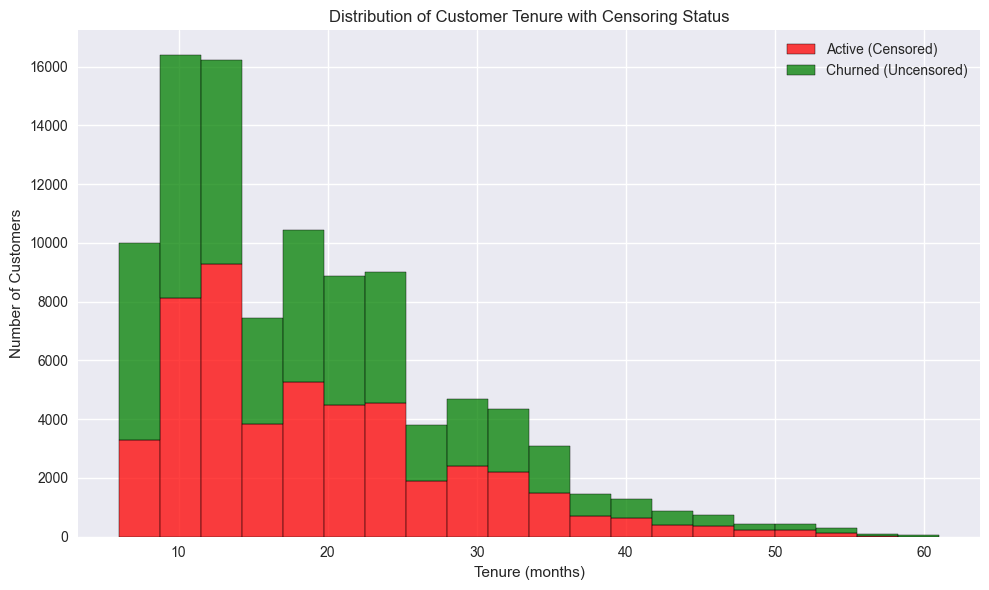

In [20]:
def explain_censoring_approach(df):
    """
    Provide a detailed explanation of the censoring approach used in the survival analysis.
    """
    print("\nCENSORING APPROACH EXPLANATION")
    print("-" * 50)
    
    # Count censored and uncensored observations
    censored_count = sum(df['churn'] == 0)
    uncensored_count = sum(df['churn'] == 1)
    total_count = len(df)
    
    print(f"Total observations: {total_count}")
    print(f"Uncensored (churned) observations: {uncensored_count} ({uncensored_count/total_count*100:.2f}%)")
    print(f"Right-censored observations: {censored_count} ({censored_count/total_count*100:.2f}%)")
    
    print("\nDefinition of Censoring in this Analysis:")
    print("- Event (churn=1): Customer has terminated service within the observation period.")
    print("- Right-censored (churn=0): Customer was still active at the end of the observation period.")
    
    print("\nImportance of Censoring:")
    print("- Right-censoring accounts for customers who haven't experienced the event by the")
    print("  end of the observation period but might do so in the future.")
    print("- Ignoring censoring would underestimate survival probabilities and lead to")
    print("  biased conclusions about customer lifetime.")
    print("- Survival analysis methods like Kaplan-Meier and parametric models properly")
    print("  account for censored observations in estimating survival functions.")
    
    # Create a visualization of censoring
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='months', hue='churn', bins=20, 
                 multiple='stack', palette=['green', 'red'])
    plt.xlabel('Tenure (months)')
    plt.ylabel('Number of Customers')
    plt.title('Distribution of Customer Tenure with Censoring Status')
    plt.legend(['Active (Censored)', 'Churned (Uncensored)'])
    plt.tight_layout()
    plt.savefig('censoring_visualization.png')
    plt.show()
    plt.close()
    


explain_censoring_approach(df)
    


# Kaplan-Meier Survival Analysis

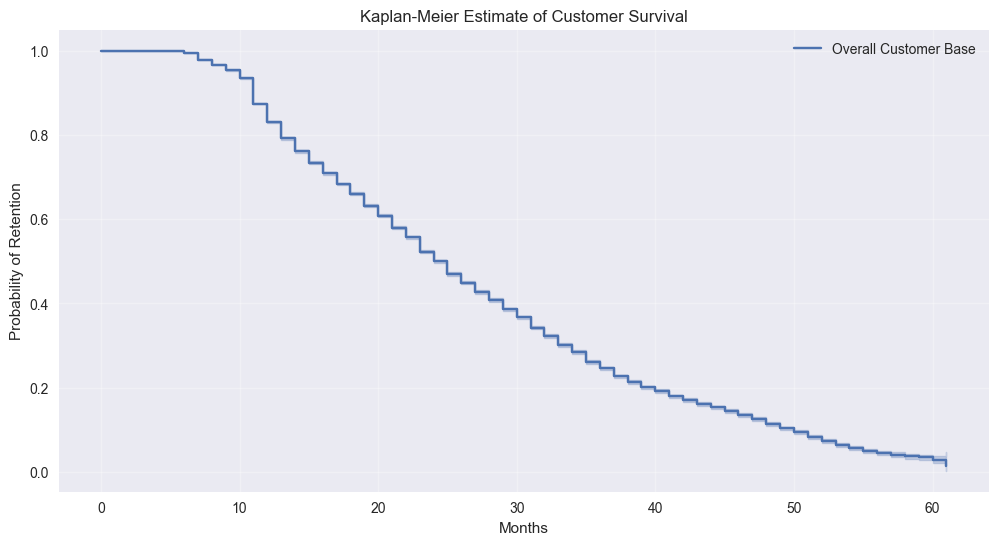

Overall survival curve saved to 'figures/overall_survival_curve.png'

Survival function (first 5 rows):


,Overall Customer Base
timeline,
0.0,1.000000
6.0,0.995030
7.0,0.978336
8.0,0.966290
9.0,0.953718
10.0,0.934439
11.0,0.874574
12.0,0.830221
13.0,0.791719



Confidence intervals (first 5 rows):


,Overall Customer Base_lower_0.95,Overall Customer Base_upper_0.95
0.0,1.000000,1.000000
6.0,0.994575,0.995447
7.0,0.977412,0.979223
8.0,0.965142,0.967402
9.0,0.952374,0.955024
10.0,0.932843,0.935999
11.0,0.872401,0.876712
12.0,0.827733,0.832677
13.0,0.789004,0.794404
14.0,0.757970,0.763694


In [21]:
# Instantiate the KaplanMeierFitter
kmf = KaplanMeierFitter()

# Fit the model
# 'months' is our duration column
# 'churn' is our event indicator (1 = churned, 0 = still active/censored)
kmf.fit(df['months'], df['churn'], label='Overall Customer Base')

# Plot the survival function
plt.figure(figsize=(12, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Estimate of Customer Survival')
plt.xlabel('Months')
plt.ylabel('Probability of Retention')
plt.grid(alpha=0.3)
plt.savefig('figures/overall_survival_curve.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Overall survival curve saved to 'figures/overall_survival_curve.png'")

# Survival function
print("\nSurvival function (first 5 rows):")
display(kmf.survival_function_)

# Confidence intervals
print("\nConfidence intervals (first 5 rows):")
display(kmf.confidence_interval_)

# Stratified Analysis by Customer Segments

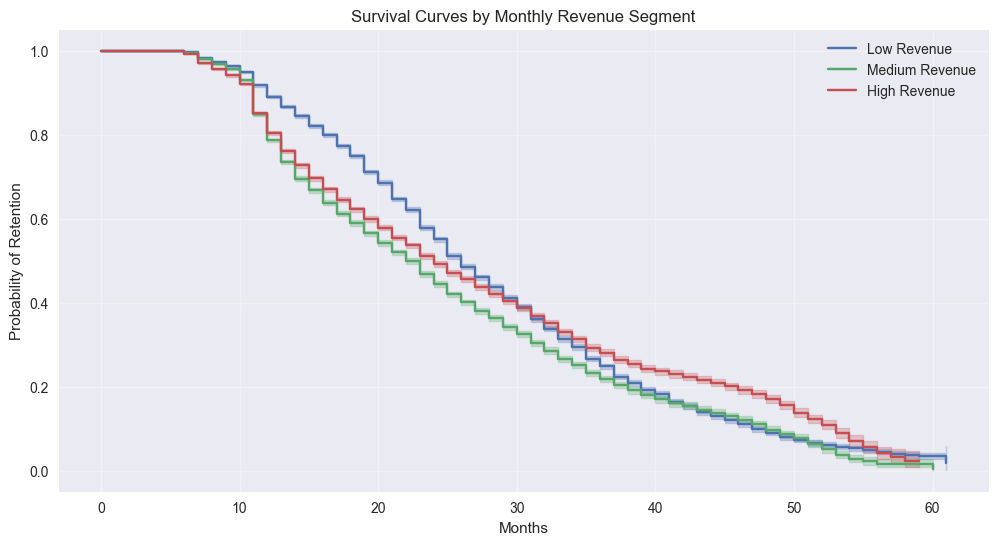

Revenue segment survival curves saved to 'figures/revenue_segment_survival.png'


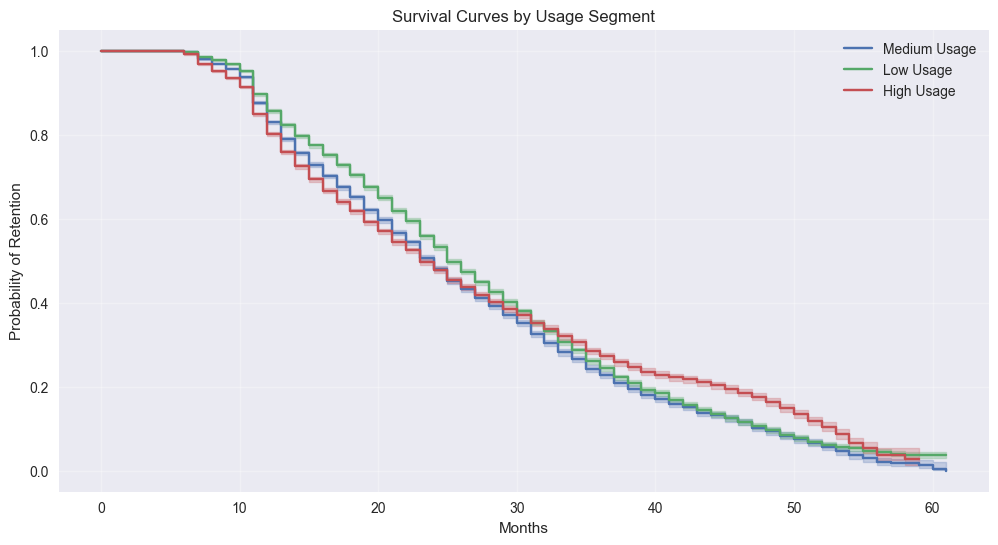

Usage segment survival curves saved to 'figures/usage_segment_survival.png'


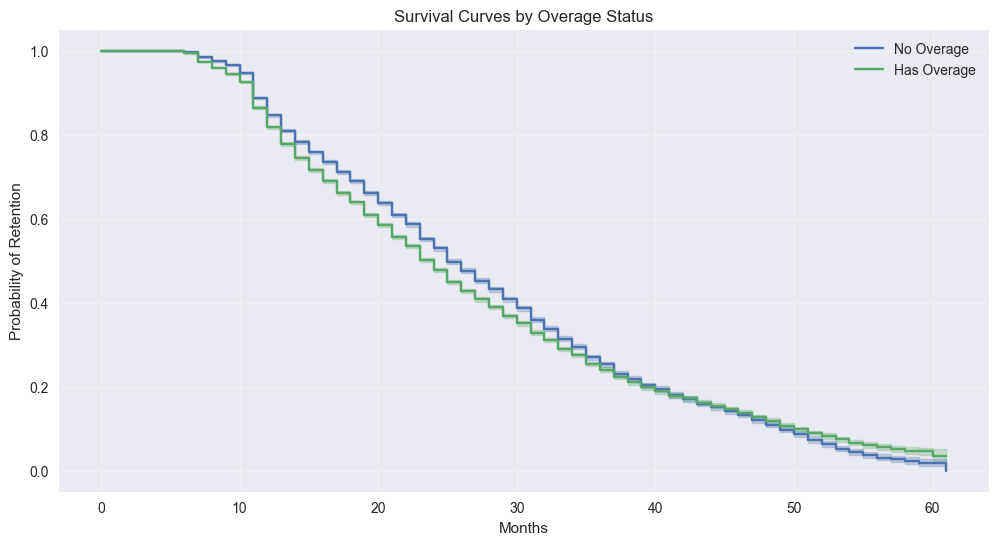

Overage status survival curves saved to 'figures/overage_survival.png'

Logrank test results for Low vs High Revenue:
p-value: 0.0000
Logrank test results for No Overage vs Has Overage:
p-value: 0.0000


In [22]:
# 4.1 Segment by Monthly Revenue (totmrc_Mean)
# Create high and low value customer segments
df['revenue_segment'] = pd.qcut(df['totmrc_Mean'], 3, labels=['Low', 'Medium', 'High'])

# Plot survival curves by revenue segment
plt.figure(figsize=(12, 6))

for segment in df['revenue_segment'].unique():
    segment_mask = (df['revenue_segment'] == segment)
    durations = df.loc[segment_mask, 'months']
    events = df.loc[segment_mask, 'churn']
    
    if durations.empty or events.empty:
        continue

    kmf = KaplanMeierFitter()
    kmf.fit(durations, events, label=f'{segment} Revenue')
    kmf.plot_survival_function()


plt.title('Survival Curves by Monthly Revenue Segment')
plt.xlabel('Months')
plt.ylabel('Probability of Retention')
plt.grid(alpha=0.3)
plt.savefig('figures/revenue_segment_survival.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Revenue segment survival curves saved to 'figures/revenue_segment_survival.png'")

# 4.2 Segment by Minutes of Use (mou_Mean)
df['usage_segment'] = pd.qcut(df['mou_Mean'], 3, labels=['Low', 'Medium', 'High'])

# Plot survival curves by usage segment
plt.figure(figsize=(12, 6))

for segment in df['usage_segment'].dropna().unique():
    segment_mask = (df['usage_segment'] == segment)
    durations = df.loc[segment_mask, 'months']
    events = df.loc[segment_mask, 'churn']

    # Skip if durations or events are empty or non-numeric
    if durations.empty or events.empty:
        print(f"Skipping segment '{segment}' — no data.")
        continue
    if not np.issubdtype(durations.dtype, np.number) or not np.issubdtype(events.dtype, np.number):
        print(f"Skipping segment '{segment}' — non-numeric data.")
        continue

    kmf = KaplanMeierFitter()
    kmf.fit(durations, events, label=f'{segment} Usage')
    kmf.plot_survival_function()

plt.title('Survival Curves by Usage Segment')
plt.xlabel('Months')
plt.ylabel('Probability of Retention')
plt.grid(alpha=0.3)
plt.savefig('figures/usage_segment_survival.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Usage segment survival curves saved to 'figures/usage_segment_survival.png'")

# 4.3 Segment by Overage Minutes (ovrmou_Mean)
# First, categorize customers into those with overage and those without
df['has_overage'] = (df['ovrmou_Mean'] > 0).astype(int)

# Plot survival curves by overage status
plt.figure(figsize=(12, 6))

# For customers with no overage
kmf_no_overage = KaplanMeierFitter()
mask_no_overage = (df['has_overage'] == 0)
kmf_no_overage.fit(df.loc[mask_no_overage, 'months'],
                  df.loc[mask_no_overage, 'churn'],
                  label='No Overage')
kmf_no_overage.plot_survival_function()

# For customers with overage
kmf_overage = KaplanMeierFitter()
mask_overage = (df['has_overage'] == 1)
kmf_overage.fit(df.loc[mask_overage, 'months'],
               df.loc[mask_overage, 'churn'],
               label='Has Overage')
kmf_overage.plot_survival_function()

plt.title('Survival Curves by Overage Status')
plt.xlabel('Months')
plt.ylabel('Probability of Retention')
plt.grid(alpha=0.3)
plt.savefig('figures/overage_survival.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Overage status survival curves saved to 'figures/overage_survival.png'")

# Perform logrank test to compare groups
# Revenue segments
low_rev = df[df['revenue_segment'] == 'Low']
high_rev = df[df['revenue_segment'] == 'High']

results = logrank_test(low_rev['months'], high_rev['months'], 
                     low_rev['churn'], high_rev['churn'])
print("\nLogrank test results for Low vs High Revenue:")
print(f"p-value: {results.p_value:.4f}")

# Overage status
no_overage = df[df['has_overage'] == 0]
has_overage = df[df['has_overage'] == 1]

results = logrank_test(no_overage['months'], has_overage['months'], 
                     no_overage['churn'], has_overage['churn'])
print("Logrank test results for No Overage vs Has Overage:")
print(f"p-value: {results.p_value:.4f}")

# Advanced Stratification


ADVANCED CUSTOMER SEGMENTATION
--------------------------------------------------
Customer Segments by Size:
- high_value: 39811 customers (39.81%)
- poor_quality: 44580 customers (44.58%)
- new_basic: 4833 customers (4.83%)
- new_advanced: 13559 customers (13.56%)
- existing_basic: 3420 customers (3.42%)
- existing_advanced: 9809 customers (9.81%)
- high_value_poor_quality: 25487 customers (25.49%)
- high_value_good_quality: 14324 customers (14.32%)
- low_value_poor_quality: 19093 customers (19.09%)
- low_value_good_quality: 41096 customers (41.10%)

Performing survival analysis for value-quality segments:


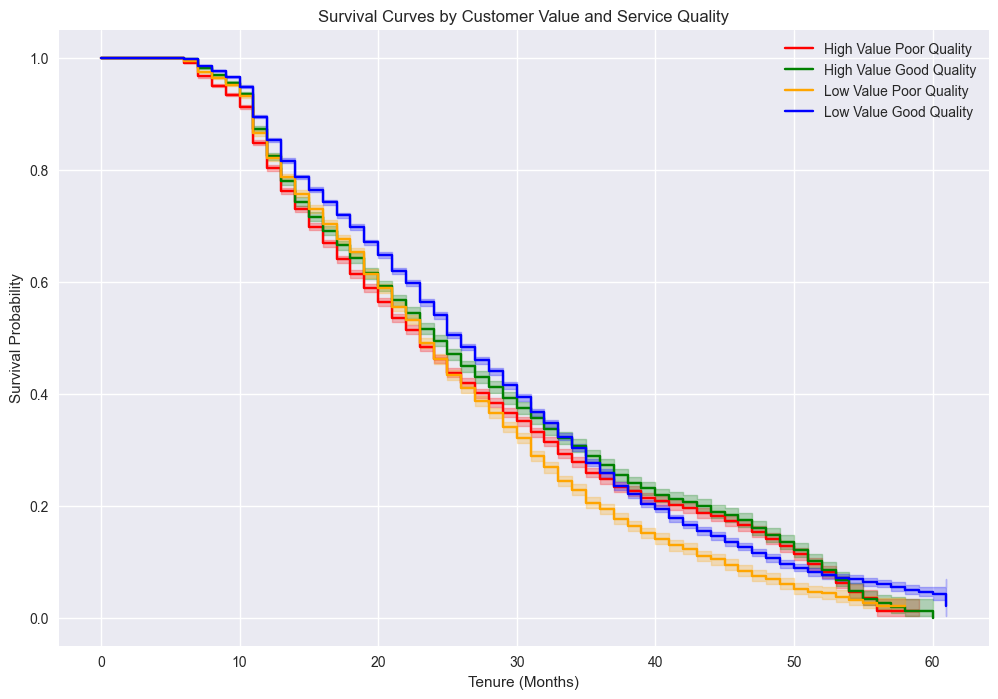

Advanced segmentation survival analysis has been saved as 'advanced_segmentation.png'


In [23]:
def perform_advanced_segmentation(df, duration_col='months', event_col='churn'):
    """
    Perform advanced segmentation by combining multiple variables to identify high-risk profiles.
    """
    print("\nADVANCED CUSTOMER SEGMENTATION")
    print("-" * 50)
    
    # Create new segment variables by combining multiple factors
    
    # Segment 1: High-value customers based on revenue and usage
    df['high_value'] = (df['avgrev'] > df['avgrev'].median()) & (df['avgmou'] > df['avgmou'].median())
    
    # Segment 2: Service quality experience
    df['poor_quality'] = df['drop_blk_Range'] > df['drop_blk_Range'].median()
    
    # Segment 3: Customer type and technology
    df['new_basic'] = (df['new_cell'] == 'Y') & (df['dualband'] == 'N')
    df['new_advanced'] = (df['new_cell'] == 'Y') & (df['dualband'] == 'Y')
    df['existing_basic'] = (df['new_cell'] == 'N') & (df['dualband'] == 'N')
    df['existing_advanced'] = (df['new_cell'] == 'N') & (df['dualband'] == 'Y')
    
    # Segment 4: Combined value and quality experience
    df['high_value_poor_quality'] = df['high_value'] & df['poor_quality']
    df['high_value_good_quality'] = df['high_value'] & (~df['poor_quality'])
    df['low_value_poor_quality'] = (~df['high_value']) & df['poor_quality']
    df['low_value_good_quality'] = (~df['high_value']) & (~df['poor_quality'])
    
    # Print segment sizes
    print("Customer Segments by Size:")
    segments = ['high_value', 'poor_quality', 'new_basic', 'new_advanced', 
                'existing_basic', 'existing_advanced', 'high_value_poor_quality',
                'high_value_good_quality', 'low_value_poor_quality', 'low_value_good_quality']
    
    for segment in segments:
        count = df[segment].sum()
        pct = count / len(df) * 100
        print(f"- {segment}: {count} customers ({pct:.2f}%)")
    
    # Perform KM analysis for the most insightful combined segment
    print("\nPerforming survival analysis for value-quality segments:")
    
    # Initialize KM fitter
    kmf = KaplanMeierFitter()
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Define segments to analyze
    value_quality_segments = [
        'high_value_poor_quality',
        'high_value_good_quality',
        'low_value_poor_quality',
        'low_value_good_quality'
    ]
    
    colors = ['red', 'green', 'orange', 'blue']
    
    # Plot survival function for each segment
    for i, segment in enumerate(value_quality_segments):
        # Get segment data
        segment_data = df[df[segment]].copy()
        
        # Fit KM model
        kmf.fit(segment_data[duration_col], event_observed=segment_data[event_col], 
                label=segment.replace('_', ' ').title())
        
        # Plot
        kmf.plot_survival_function(ax=plt.gca(), color=colors[i])
    
    plt.title('Survival Curves by Customer Value and Service Quality')
    plt.xlabel('Tenure (Months)')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    plt.savefig('advanced_segmentation.png')
    plt.show()
    plt.close()
    
    print("Advanced segmentation survival analysis has been saved as 'advanced_segmentation.png'")
    
    # Return the enriched DataFrame and key segments
    return df, value_quality_segments


df_enriched, key_segments = perform_advanced_segmentation(df, duration_var, event_var)
    



### Customer Segmentation Analysis

**Customer Value Dimension:**
This divides customers based on their revenue and usage patterns.

- **High-Value Customers:**
  Those whose average revenue (`avgrev`) and average minutes of use (`avgmou`) are both above the median.

- **Low-Value Customers:**
  Those who don't meet both criteria.

**Service Quality Experience Dimension:**
This categorizes customers based on their experienced service quality.

- **Poor-Quality Customers:**
  Those with dropped/blocked call rates (`drop_blk_Range`) above the median.

- **Good-Quality Customers:**
  Those with dropped/blocked call rates below the median.

**Customer Segments:**
By crossing these two dimensions, the analysis creates four distinct customer segments:

1. **High-Value Poor-Quality:**
   High-spending customers experiencing poor service quality.

2. **High-Value Good-Quality:**
   High-spending customers with good service experience.

3. **Low-Value Poor-Quality:**
   Lower-value customers experiencing poor service quality.

4. **Low-Value Good-Quality:**
   Lower-value customers with good service experience.


# Statistical Testing


STATISTICAL TESTING WITH LOG-RANK TESTS
--------------------------------------------------
Log-rank Tests for Simple Group Comparisons:

new_cell - Y vs N:
  Test statistic: 95.9619
  P-value: 0.0000
  Statistical significance: Yes

asl_flag - Y vs N:
  Test statistic: 3655.1021
  P-value: 0.0000
  Statistical significance: Yes

dualband - Y vs N:
  Test statistic: 575.6727
  P-value: 0.0000
  Statistical significance: Yes

Log-rank Tests for Advanced Segments:

High Value vs Low Value:
  Test statistic: 58.8469
  P-value: 0.0000
  Statistical significance: Yes

Poor Quality vs Good Quality:
  Test statistic: 295.8366
  P-value: 0.0000
  Statistical significance: Yes

High Value with Poor Quality vs Others:
  Test statistic: 94.4416
  P-value: 0.0000
  Statistical significance: Yes

Pairwise Log-rank Tests for Multi-category Variable:
Pairwise comparisons for prizm_social_one (6 categories):
  S vs U:
    Test statistic: 9.5570
    P-value: 0.0020
    Statistical significance: Yes
  S

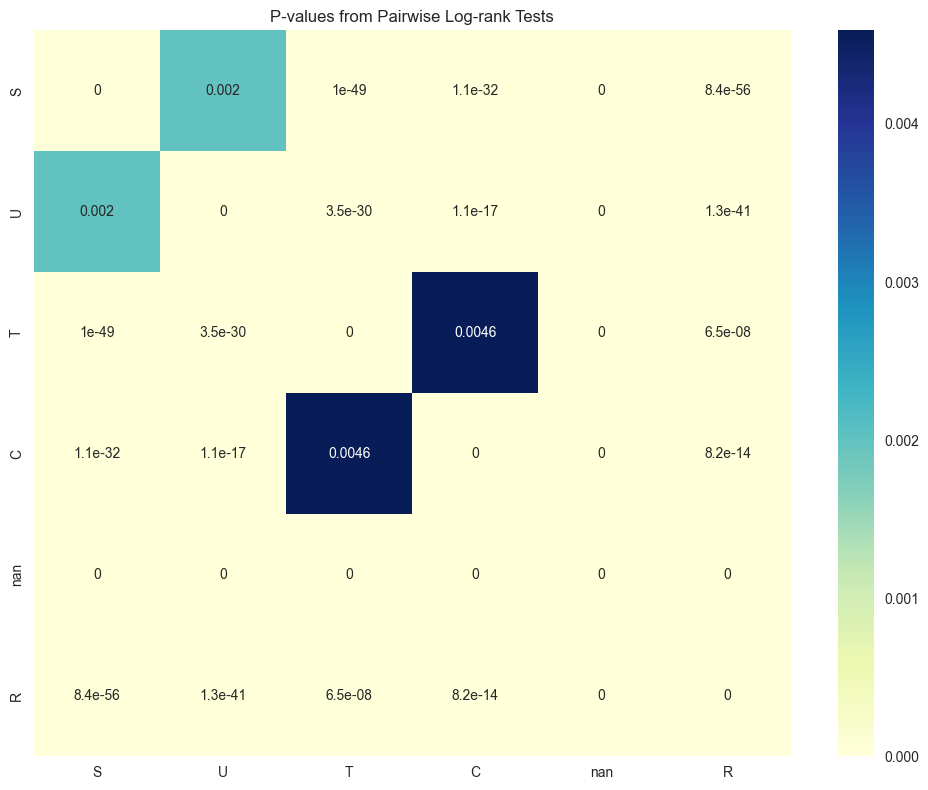


Heatmap of p-values from pairwise log-rank tests has been saved as 'logrank_pvalues_heatmap.png'


In [24]:
def perform_logrank_tests(df, duration_col='months', event_col='churn'):
    """
    Perform log-rank tests to statistically compare survival curves between groups.
    """
    print("\nSTATISTICAL TESTING WITH LOG-RANK TESTS")
    print("-" * 50)
    
    # 1. Simple variable groups
    simple_vars = {
        'new_cell': ['Y', 'N'],
        'asl_flag': ['Y', 'N'],
        'dualband': ['Y', 'N']
    }
    
    print("Log-rank Tests for Simple Group Comparisons:")
    for var, groups in simple_vars.items():
        if all(g in df[var].unique() for g in groups):
            # Extract data for the two groups
            group1 = df[df[var] == groups[0]]
            group2 = df[df[var] == groups[1]]
            
            # Perform log-rank test
            results = logrank_test(
                group1[duration_col], group2[duration_col],
                group1[event_col], group2[event_col]
            )
            
            # Print results
            print(f"\n{var} - {groups[0]} vs {groups[1]}:")
            print(f"  Test statistic: {results.test_statistic:.4f}")
            print(f"  P-value: {results.p_value:.4f}")
            print(f"  Statistical significance: {'Yes' if results.p_value < 0.05 else 'No'}")
    
    # 2. Advanced segments from the previous function
    print("\nLog-rank Tests for Advanced Segments:")
    segments_to_test = [
        ('high_value', 'High Value', 'Low Value'),
        ('poor_quality', 'Poor Quality', 'Good Quality'),
        ('high_value_poor_quality', 'High Value with Poor Quality', 'Others')
    ]
    
    for segment, label1, label2 in segments_to_test:
        # Extract data for the two groups
        group1 = df[df[segment]]
        group2 = df[~df[segment]]
        
        # Perform log-rank test
        results = logrank_test(
            group1[duration_col], group2[duration_col],
            group1[event_col], group2[event_col]
        )
        
        # Print results
        print(f"\n{label1} vs {label2}:")
        print(f"  Test statistic: {results.test_statistic:.4f}")
        print(f"  P-value: {results.p_value:.4f}")
        print(f"  Statistical significance: {'Yes' if results.p_value < 0.05 else 'No'}")
    
    # 3. Pairwise comparisons for multi-category variable
    print("\nPairwise Log-rank Tests for Multi-category Variable:")
    # Example with prizm_social_one (if it has multiple categories)
    if 'prizm_social_one' in df.columns:
        categories = df['prizm_social_one'].unique()
        if len(categories) > 1:
            print(f"Pairwise comparisons for prizm_social_one ({len(categories)} categories):")
            
            # Create a matrix to store p-values
            n_categories = len(categories)
            p_values = np.zeros((n_categories, n_categories))
            
            # Perform pairwise log-rank tests
            for i in range(n_categories):
                for j in range(i+1, n_categories):
                    cat_i = categories[i]
                    cat_j = categories[j]
                    
                    group_i = df[df['prizm_social_one'] == cat_i]
                    group_j = df[df['prizm_social_one'] == cat_j]
                    
                    if len(group_i) > 0 and len(group_j) > 0:
                        results = logrank_test(
                            group_i[duration_col], group_j[duration_col],
                            group_i[event_col], group_j[event_col]
                        )
                        
                        print(f"  {cat_i} vs {cat_j}:")
                        print(f"    Test statistic: {results.test_statistic:.4f}")
                        print(f"    P-value: {results.p_value:.4f}")
                        print(f"    Statistical significance: {'Yes' if results.p_value < 0.05 else 'No'}")
                        
                        # Store p-value
                        p_values[i, j] = results.p_value
                        p_values[j, i] = results.p_value
            
            # Plot heatmap of p-values if there are multiple categories
            if n_categories > 2:
                plt.figure(figsize=(10, 8))
                sns.heatmap(p_values, annot=True, cmap='YlGnBu', 
                            xticklabels=categories, yticklabels=categories)
                plt.title('P-values from Pairwise Log-rank Tests')
                plt.tight_layout()
                plt.savefig('logrank_pvalues_heatmap.png')
                plt.show()
                plt.close()
                print("\nHeatmap of p-values from pairwise log-rank tests has been saved as 'logrank_pvalues_heatmap.png'")


perform_logrank_tests(df_enriched, duration_var, event_var)

# Parametric Survival Models

In [25]:
# Prepare the data for parametric models
# Select important predictors based on domain knowledge and data exploration
predictors = ['totmrc_Mean', 'mou_Mean', 'ovrmou_Mean', 'rev_Mean', 'drop_vce_Mean', 'custcare_Mean']

# Create a dataframe with predictors, duration and event indicator
model_df = df[predictors + ['months', 'churn']].copy()

# Check for missing values in the modeling dataset
print("Missing values in the modeling dataset:")
print(model_df.isnull().sum())

# Drop rows with missing values
model_df = model_df.dropna()
print(f"Shape after dropping missing values: {model_df.shape}")

# 5.1 Fit Weibull AFT model
print("\nFitting Weibull AFT model...")
waft = WeibullAFTFitter()
waft.fit(model_df, duration_col='months', event_col='churn')

# Display model summary
print("Weibull AFT Model Summary:")
waft_summary = waft.summary
print(waft_summary)
waft_summary.to_csv('weibull_model_summary.csv')

# 5.2 Fit Log-Logistic AFT model
print("\nFitting Log-Logistic AFT model...")
llaft = LogLogisticAFTFitter()
llaft.fit(model_df, duration_col='months', event_col='churn')

# Display model summary
print("Log-Logistic AFT Model Summary:")
llaft_summary = llaft.summary
print(llaft_summary)
llaft_summary.to_csv('loglogistic_model_summary.csv')

# 5.3 Fit Exponential model
print("\nFitting Exponential model...")
exp_fit = ExponentialFitter()
exp_fit.fit(model_df['months'], model_df['churn'])

# Display model fit
print("Exponential Model:")
print(f"Lambda (rate parameter): {exp_fit.lambda_}")

# 5.4 Compare models using AIC
print("\nModel Comparison using AIC:")
print(f"Weibull AFT AIC: {waft.AIC_}")
print(f"Log-Logistic AFT AIC: {llaft.AIC_}")

# Save model comparison to text file
with open('model_comparison.txt', 'w') as f:
    f.write("Model Comparison using AIC:\n")
    f.write(f"Weibull AFT AIC: {waft.AIC_}\n")
    f.write(f"Log-Logistic AFT AIC: {llaft.AIC_}\n")
    f.write(f"Exponential lambda: {exp_fit.lambda_}\n")

# Plot the predicted survival curves of the different models
plt.figure(figsize=(12, 6))

# Original KM curve
kmf = KaplanMeierFitter()
kmf.fit(model_df['months'], model_df['churn'], label='KM Estimate')
kmf.plot_survival_function()

# Weibull predicted curve
waft_pred = waft.predict_survival_function(model_df.iloc[:1])
plt.plot(waft_pred.index, waft_pred.iloc[:, 0], label='Weibull AFT')

# Log-Logistic predicted curve
llaft_pred = llaft.predict_survival_function(model_df.iloc[:1])
plt.plot(llaft_pred.index, llaft_pred.iloc[:, 0], label='Log-Logistic AFT')

plt.title('Comparison of Parametric Survival Models')
plt.xlabel('Months')
plt.ylabel('Survival Probability')
plt.grid(alpha=0.3)
plt.legend()
plt.savefig('figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

Missing values in the modeling dataset:
totmrc_Mean      357
mou_Mean         357
ovrmou_Mean      357
rev_Mean         357
drop_vce_Mean      0
custcare_Mean      0
months             0
churn              0
dtype: int64
Shape after dropping missing values: (99643, 8)

Fitting Weibull AFT model...
Weibull AFT Model Summary:
                           coef  exp(coef)  se(coef)  coef lower 95%  \
param   covariate                                                      
lambda_ custcare_Mean -0.001998   0.998004  0.000169       -0.002329   
        drop_vce_Mean -0.002085   0.997917  0.000295       -0.002662   
        mou_Mean      -0.000004   0.999996  0.000007       -0.000018   
        ovrmou_Mean   -0.000109   0.999891  0.000033       -0.000174   
        rev_Mean       0.000321   1.000321  0.000110        0.000105   
        totmrc_Mean    0.000597   1.000597  0.000147        0.000309   
        Intercept      3.369395  29.060938  0.004404        3.360764   
rho_    Intercept      0.7

# Model Selection and Interpretation

In [26]:
# Interpret the coefficients of the Weibull model
waft_summary = waft.summary

# Sort by absolute value of coef to identify most influential factors
waft_summary['abs_coef'] = waft_summary['coef'].abs()
waft_summary = waft_summary.sort_values('abs_coef', ascending=False)

# Display sorted coefficients
print("Sorted Model Coefficients by Influence Magnitude:")
print(waft_summary[['coef', 'exp(coef)', 'p']])

# Save sorted coefficients to CSV
waft_summary[['coef', 'exp(coef)', 'p', 'abs_coef']].to_csv('sorted_coefficients.csv')

# Visualize coefficient effects
plt.figure(figsize=(10, 6))
coefs = waft_summary['coef']
exp_coefs = waft_summary['exp(coef)']
variables = coefs.index.get_level_values(1)

# Removing the intercept for better visualization
mask = variables != 'Intercept'
coefs = coefs[mask]
exp_coefs = exp_coefs[mask]
variables = variables[mask]

plt.barh(variables, coefs)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Weibull AFT Model Coefficients')
plt.xlabel('Coefficient Value')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/model_coefficients.png', dpi=300, bbox_inches='tight')
plt.close()

print("Model coefficients plot saved to 'figures/model_coefficients.png'")

Sorted Model Coefficients by Influence Magnitude:
                           coef  exp(coef)             p
param   covariate                                       
lambda_ Intercept      3.369395  29.060938  0.000000e+00
rho_    Intercept      0.765234   2.149497  0.000000e+00
lambda_ drop_vce_Mean -0.002085   0.997917  1.474382e-12
        custcare_Mean -0.001998   0.998004  1.969802e-32
        totmrc_Mean    0.000597   1.000597  4.706050e-05
        rev_Mean       0.000321   1.000321  3.556421e-03
        ovrmou_Mean   -0.000109   0.999891  9.802890e-04
        mou_Mean      -0.000004   0.999996  6.091051e-01
Model coefficients plot saved to 'figures/model_coefficients.png'
